In [51]:
import sys
import importlib
import matplotlib.colors as mcolors
COLORS = list(mcolors.TABLEAU_COLORS.keys())
sys.path.append('..')  # Go up one directory to where utils.py is located
import utils  # Ensure you import the module itself, not specific items
importlib.reload(utils)  # Reload the module to apply updates
from utils import *

In [52]:
def analytic_solution(iv, t):
    
    N = iv.shape[-1] // 2
    
    t = t[None, :,None]
    iv = iv[:,None,:]
    

    p = iv[:,:,1:N]
    q = iv[:,:,N+1:]    
    
    
    p0 = iv[:,:,None,0]
    q0 = iv[:,:,None,N]
    
    
        
    k = np.arange(1, N)[None,None,:]
   
    
    p_new = p * np.cos(2 * np.pi * k * t) - q * np.sin(2 * np.pi * k * t) * (2 * np.pi * k)
        
    q_new = q * np.cos(2 * np.pi * k * t) + p * np.sin(2 * np.pi * k * t) / (2 * np.pi * k)
    
    p0_new = p0 * np.ones_like(t)
    q0_new = q0 + p0 * t
    
    y = np.concat((p0_new, p_new, q0_new, q_new), axis=-1)    
    
    
    return y
        
    


In [53]:
def get_data(num_iv=10, num_t=10,  N=10, Tmax=1, random=True):
    
    iv = np.random.uniform(low=-1, high=1, size=(num_iv, 2*N)).astype(np.float32)


    if random:
        if num_t > 1:
            t = np.random.uniform(low=0, high=Tmax, size=(num_t)).astype(np.float32)
        else:
            t = np.array([Tmax]).astype(np.float32)
    else:
        t = np.linspace(0, Tmax, num_t).astype(np.float32)


    
    y = analytic_solution(iv, t)
    X = (iv, t[:,None])
    
    return X, y

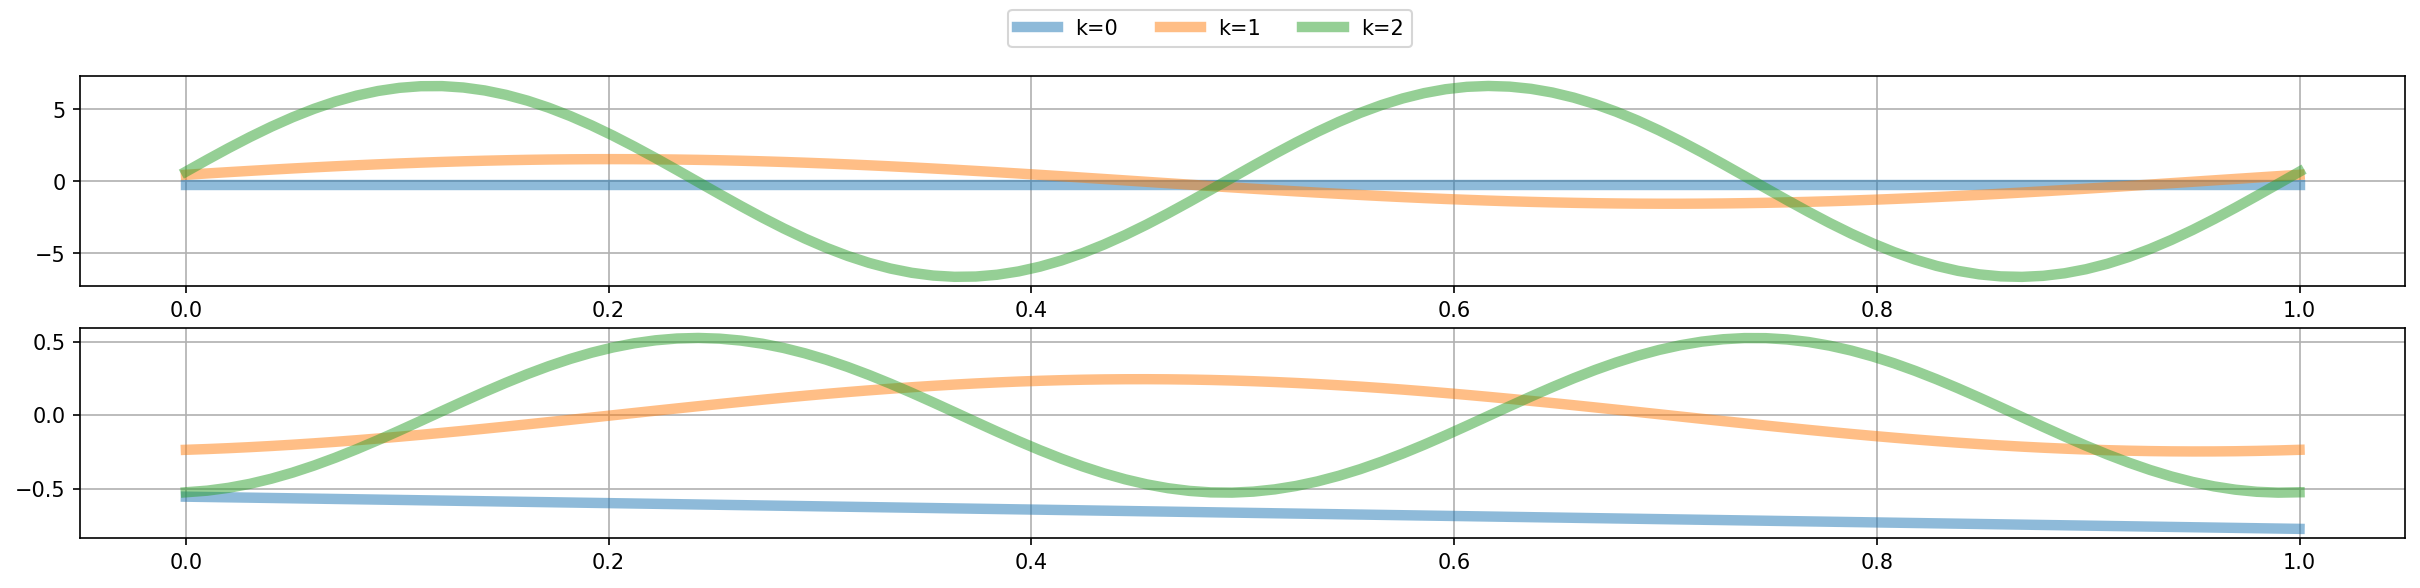

In [54]:
def plot_data(t, y):
    fig, ax = plt.subplots(2, 1, figsize=(20, 4), dpi=150)

    handles, labels = [], []

    for i in range(y.shape[0]):
        for j in range(N):
            
            t = np.linspace(0, Tmax, y.shape[1])
            
            line, = ax[0].plot(t, y[i,...,j], linewidth=5, c=COLORS[j], alpha=0.5)
            line, = ax[1].plot(t, y[i,...,j+N], linewidth=5, c=COLORS[j], alpha=0.5)
                    
            
            if i == 0:
                handles.append(line)
                labels.append(f'k={j}')
            

    ax[0].grid(True)
    ax[1].grid(True)
    fig.legend(handles, labels, loc="upper center", ncol=len(labels), fontsize=10)
    plt.show()
    
N, Tmax = 3, 1
x, y = get_data(num_iv=1, num_t=100, random=False, N=N, Tmax=Tmax)
t = x[1]

plot_data(t, y)
    
    

In [55]:
N = 6
X_train, y_train = get_data(num_iv=100, num_t=1, Tmax=0.01, N=N)
X_test, y_test = get_data(num_iv=100, num_t=1, Tmax=0.01, N=N)

In [56]:
net = DeepONet([20, 20, 20], [40, 40, 40], activation='htanh', N=N, scheme=3, L=3)
model = Model(X_train, y_train, X_test, y_test, net)
model.train(iterations=10_000)
model.plot_losshistory()

Step 	 Train loss 	 Test loss
1000 	 [7.74e-08] 	 [6.59e-08] 	 New best model!
2000 	 [7.16e-13] 	 [6.21e-13] 	 New best model!


KeyboardInterrupt: 

tensor([[[-0.0049,  0.0796, -0.0662,  0.2171, -0.6838, -0.1219]]],
       grad_fn=<SliceBackward0>)


/var/folders/43/0xc7h8213cs2gpcym99hxdqm0000gn/T/ipykernel_31574/545881904.py:34: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


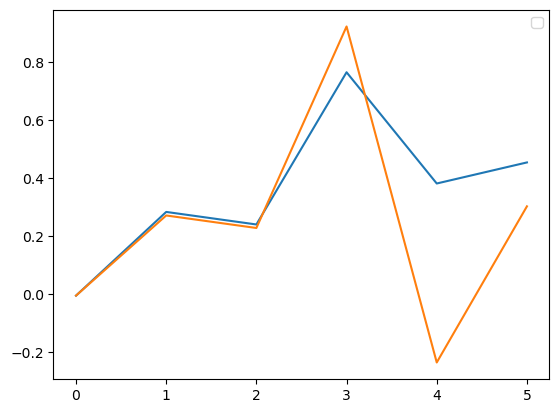

In [266]:
iters = 12
h = 0.01
T = h * iters
t = np.linspace(h, T, iters+1)
x = np.arange(6)
h = torch.tensor([[h]], dtype=torch.float32)

iv = np.random.uniform(low=-0.1, high=0.1, size=(1, 12)).astype(np.float32)


conj_momenta = model.predict(model.format(iv), h)

pred = conj_momenta[:,:,:6]

print(pred)
sol = analytic_solution(iv, t)

true = sol[:,:,:6]

for _ in range(iters):
    


    conj_momenta = model.predict(conj_momenta.squeeze(1), h)    
    pred = torch.concatenate((pred, conj_momenta[:,:,:6]), axis=1)
    

    
#for i in range(iters):
    #plt.plot(x, np.abs((pred[0,i,:].detach() - true[0,i,:])/true[0,i,:]), label=f'{i}')
plt.plot(x, pred[0,-1,:].detach())
plt.plot(x, true[0,-1,:])
    
plt.legend()
    
plt.show()


tensor([[[ 0.0060, -0.2983, -0.7690, -0.9514, -0.7688, -0.2932,  0.2945,
           0.7700,  0.9507,  0.7699,  0.2895]]], dtype=torch.float64)


/Users/johanslettengren/Desktop/Dissertation/Structure-Preserving-Operator-Learning/Tests/utils.py:268: UserWarning: Casting complex values to real discards the imaginary part (Triggered internally at /private/var/folders/sy/f16zz6x50xz3113nwtb9bvq00000gp/T/abs_9d8o396w63/croot/libtorch_1736205317317/work/aten/src/ATen/native/Copy.cpp:308.)
  return x.to(torch.float32).requires_grad_(requires_grad)
/var/folders/43/0xc7h8213cs2gpcym99hxdqm0000gn/T/ipykernel_31574/4125777189.py:31: DeprecationWarning: __array_wrap__ must accept context and return_scalar arguments (positionally) in the future. (Deprecated NumPy 2.0)
  print(pred - np.fft.irfft(iv[0,:6], n=11))


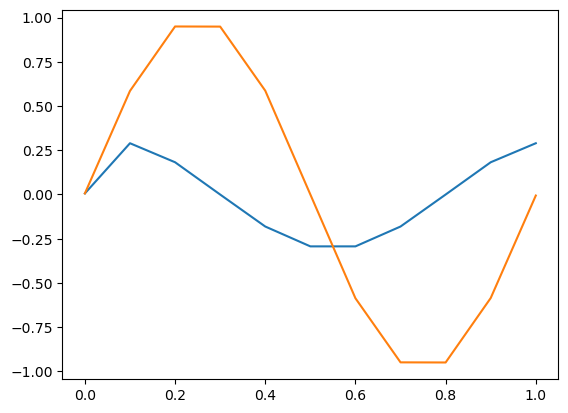

In [58]:
iters = 1
h = 0.01
T = h * iters
t = np.linspace(h, T, iters+1)
h = torch.tensor([[h]], dtype=torch.float32)



x = np.linspace(0, 1, 11)
y = np.sin(2*np.pi*x)

c = np.fft.rfft(y)



iv = np.concat((c, np.zeros_like(c)))[None,:]



conj_momenta = model.predict(model.format(iv), h)

pred = torch.fft.irfft(conj_momenta[:,:,:6], n=11).detach()

sol = analytic_solution(iv, t)




true = np.fft.irfft(sol[:,:,:6], n=11)

print(pred - np.fft.irfft(iv[0,:6], n=11))


t_curr = 0
for _ in range(iters):


    conj_momenta = model.predict(conj_momenta.squeeze(1), h)    
    pred = torch.concatenate((pred, torch.fft.irfft(conj_momenta[:,:,:6], n=11).detach()), axis=1)
    
#for i in range(pred.shape[1]):
    
    #time = (i).item()
plt.plot(x, pred[0,0,:])
plt.plot(x, true[0,0,:])
    
plt.show()


(6,)


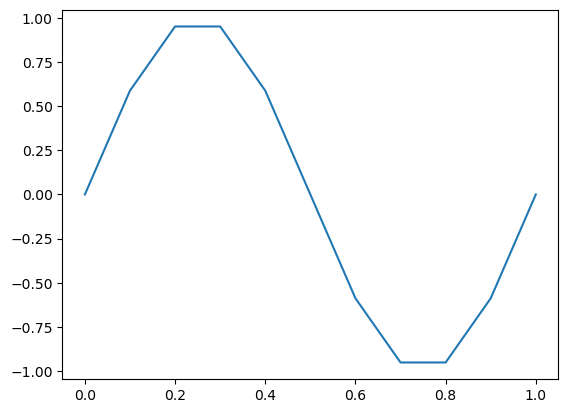

In [59]:
N, Tmax = 3, 1
x, y = get_data(num_iv=2, num_t=100, random=False, N=N, Tmax=Tmax)

t = x[1]

t = np.linspace(0, 1, 11)
y = np.sin(2*np.pi * t)


print(np.fft.rfft(y).shape)

plt.plot(t, y)
plt.show()


In [60]:
def test_symplecticity(model, T=1, num_pts=100):

                
                
    X_train, _ = get_data(num_iv=100, num_t=1, Tmax=0.01, N=N)
    
    iv = model.format(X_train[0], requires_grad=True)
    t = model.format(X_train[1])
    
    u = model.net(iv,t)[:,0,:]

    D = torch.stack([grad(u[:,i], iv, grad_outputs=torch.ones_like(u[:,i]), retain_graph=True)[0] for i in range(u.shape[1])], axis=-1)
    #print(grad(u[:,0], iv, grad_outputs=torch.ones_like(u[:,0]), retain_graph=True)[0].shape)
    D = D.squeeze(1)
    J = model.net.J


    DTJD = torch.matmul(D.transpose(1, 2), torch.matmul(J, D))    
    deltaJ = torch.linalg.norm(DTJD - J, ord=2, dim=(1, 2)).numpy()
    
    print(deltaJ)
    
test_symplecticity(model, T=0.01, 1)

SyntaxError: positional argument follows keyword argument (1079023546.py, line 23)